In [1]:
# Author : Manish
# Roll No : CS22MTECH11008

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Question 3 : CNN with Self Attention
### Downloading CIFAR 10 Dataset

In [2]:
# Define the transform for the data
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
data_dir = './dara'
train_dataset = CIFAR10(root = data_dir, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root = data_dir, train=False, download=True, transform=transform)

batch_size = 128
# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 90170609.44it/s]


Extracting ./dara/cifar-10-python.tar.gz to ./dara
Files already downloaded and verified


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# defining self attention class
class Self_Attention(nn.Module):
    def __init__(self, in_channels):
        super(Self_Attention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)

        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        out = self.gamma * out + x
        return out


class CNNWithSelfAttention(nn.Module):
  def __init__(self):
    super(CNNWithSelfAttention, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.attention1 = Self_Attention(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.attention2 = Self_Attention(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.attention3 = Self_Attention(256)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(256 * 4 * 4, 512)
    self.bn4 = nn.BatchNorm1d(512)

    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = self.attention1(x)
      x = self.pool1(x)

      x = F.relu(self.bn2(self.conv2(x)))
      x = self.attention2(x)
      x = self.pool2(x)

      x = F.relu(self.bn3(self.conv3(x)))
      x = self.attention3(x)
      x = self.pool3(x)

      x = x.view(x.size(0), -1)
      x = F.relu(self.bn4(self.fc1(x)))
      x = self.fc2(x)

      return x

In [7]:
# Define the model
model = CNNWithSelfAttention()

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # SGD with momentum and l2 regularization
epochs = 1   # change the number of epochs 1 is choosen as it is taking time
# Train the model
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# Test the model
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))

[Epoch 1] loss: 1.459
Accuracy of the model on the test images: 58 %


## Question 1 : Auto Encoder

### Downloading MNIST data set and splitting into train and test sets

In [8]:
data_dir = 'dataset'

#Download the MNIST data set
train_dataset = MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
batch_size=128

# create data loader for training and testing
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 309677190.75it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24551214.80it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85150103.38it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6850244.07it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Doing auto encoder functionality using Conv Layers

In [9]:
# defining class for encoder and decoder
class AutoEncoder(nn.Module):
  def __init__(self, hidden_dim):
    super(AutoEncoder,self).__init__()

    # encoder with 2 convolution layers
    self.encoder = nn.Sequential(
        # 28 x 28
        nn.Conv2d(1, 8, 3),
        # 8 x 26 x 26
        nn.ReLU(True),

        nn.Conv2d(8, 16, 3),
        # 16 x 24 x 24
        nn.ReLU(True),

        # flattening the feature map and mapping to the hidden space
        nn.Flatten(),
        nn.Linear(16*24*24, 256),
        nn.ReLU(True),
        nn.Linear(256, hidden_dim),
    )
    
    # decoder with transposed conv layers
    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim, 256),
        nn.ReLU(True),

        nn.Linear(256, 16*24*24),
        nn.ReLU(True),

        # unflattening the vectors and feeding to transpose conv layers
        nn.Unflatten(1, (16,24,24)),
        nn.ConvTranspose2d(16,8,3),
        nn.ReLU(True),

        nn.ConvTranspose2d(8,1,3),
        nn.Sigmoid(),

    )

  def forward(self, input):
    enocoded = self.encoder(input)
    decoded = self.decoder(enocoded)
    return decoded

### Training the Auto Encoder

In [12]:
autoencoder_64 = AutoEncoder(64)
autoencoder_32 = AutoEncoder(32)
loss_fn = nn.MSELoss()
lr = 0.01
# using Adam optimizer with l2 regularization
optimizer_64 = torch.optim.Adam(autoencoder_64.parameters(), lr=lr, weight_decay=1e-05)
optimizer_32 = torch.optim.Adam(autoencoder_32.parameters(), lr=lr, weight_decay=1e-05)
epochs = 5

train_loss_64= []
train_loss_32= []
for epoch in range(epochs):
  epoch_loss_64 = []
  epoch_loss_32 = []
  for img, label in train_data_loader:
    # feed auto encoder with input images
    output_64 = autoencoder_64(img)
    output_32 = autoencoder_32(img)
    
    # compute loss on both the types of auto encoders
    loss1 = loss_fn(output_64, img)
    loss2 = loss_fn(output_32, img)

    # making the gradients zero initailly
    optimizer_64.zero_grad()
    optimizer_32.zero_grad()

    # back propagation
    loss1.backward()
    loss2.backward()
    epoch_loss_64.append(loss1.item())
    epoch_loss_32.append(loss2.item())
    
    # updating the parameters
    optimizer_64.step()
    optimizer_32.step()
    
  mean_loss_64 = np.mean(epoch_loss_64)
  mean_loss_32 = np.mean(epoch_loss_32)
  print('epoch [{}/{}], loss_64: {:.4f}, loss_32: {:.4f}'.format(epoch+1, epochs, mean_loss_64, mean_loss_32))

epoch [1/5], loss_64: 0.0334, loss_32: 0.1123
epoch [2/5], loss_64: 0.0157, loss_32: 0.0863
epoch [3/5], loss_64: 0.0136, loss_32: 0.0675
epoch [4/5], loss_64: 0.0117, loss_32: 0.0674
epoch [5/5], loss_64: 0.0108, loss_32: 0.0674


### Function to test the Auto Encoder and to Reconstruct the images

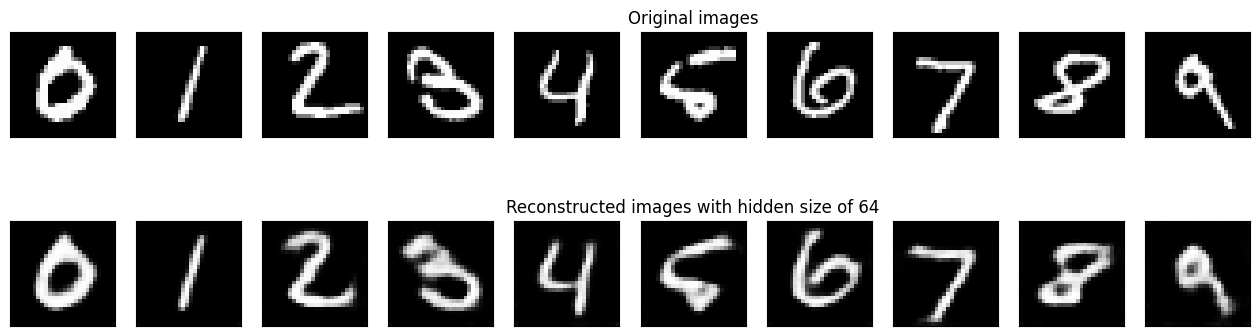

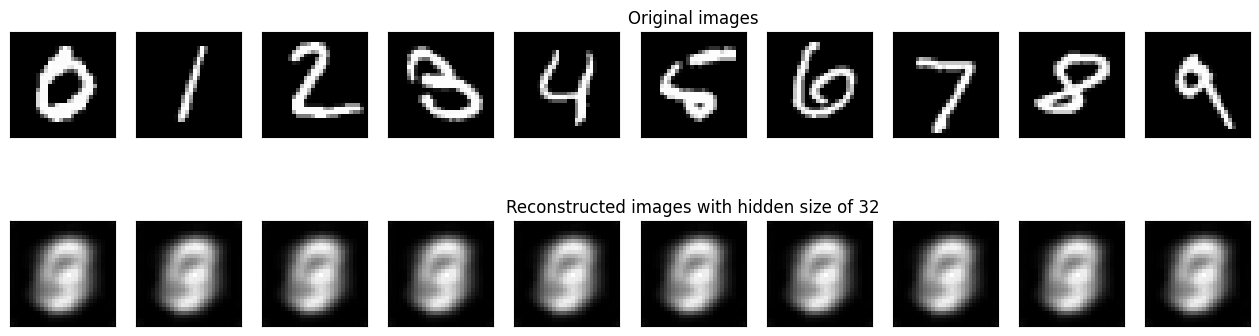

In [13]:
def reconstruction(n, autoencoder, hidden_dim):
  targets = test_dataset.targets.numpy()
  # dictionary with keys from 0 to n-1 and values are the index of the first occurrence of each integer in the targets array.
  target_index = {}
  plt.figure(figsize=(16,4.5))
  for i in range(n):
    target_index[i] = np.where(targets == i)[0][0]

  # for every image, display orignal image and reconstructed image
  for i in range(n):
    ax = plt.subplot(2,n,i+1)
    img = test_dataset[target_index[i]][0].unsqueeze(0)
    rec_img = autoencoder(img)
    plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
      ax.set_title('Original images')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(rec_img.squeeze().detach().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == n//2:
        ax.set_title('Reconstructed images with hidden size of {}'.format(hidden_dim))
  plt.show()

reconstruction(10, autoencoder_64, 64)
reconstruction(10, autoencoder_32, 32)

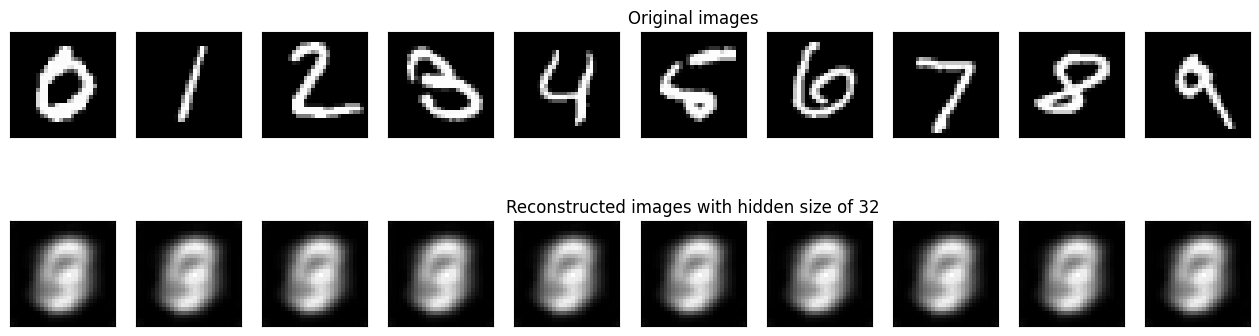

In [15]:
reconstruction(10, autoencoder_32, 32)

In [ ]:
# select two random samples from the training data loader
for i, (img, label) in enumerate(train_data_loader):
    if i == 0:
        sample1 = img[0]
    elif i == 1:
        sample2 = img[0]
    elif i > 1 and i <= 6:
        # Generate points between the samples
        num_points = 10
        latent1 = autoencoder_32.encoder(sample1.unsqueeze(0))[0]
        latent2 = autoencoder_32.encoder(sample2.unsqueeze(0))[0]
        points = torch.linspace(latent1, latent2, num_points)

        # Decode the generated points
        decoded_points = autoencoder_32.decoder(points)

        # Display the decoded points as images
        fig, axs = plt.subplots(nrows=1, ncols=num_points, figsize=(10, 2))
        for j in range(num_points):
            axs[j].imshow(decoded_points[j].detach().numpy()[0], cmap='gray')
            axs[j].axis('off')
        plt.show()

        # update the samples
        sample1 = img[0]
        sample2 = img[1]
    else:
        break


## Question 2: Variational AutoEncoder

In [10]:
import torch
import torch.nn as nn


class VAE1(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


100%|██████████| 9912422/9912422 [00:00<00:00, 290088062.77it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 80063247.74it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 178446986.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3826944.31it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Epoch [1/10], Step [938/938], Total Loss: 4462.0767
Epoch [2/10], Step [938/938], Total Loss: 3916.6995
Epoch [3/10], Step [938/938], Total Loss: 3715.8005
Epoch [4/10], Step [938/938], Total Loss: 3580.4705
Epoch [5/10], Step [938/938], Total Loss: 3331.7998
Epoch [6/10], Step [938/938], Total Loss: 3336.1494
Epoch [7/10], Step [938/938], Total Loss: 3595.9253
Epoch [8/10], Step [938/938], Total Loss: 3326.9524
Epoch [9/10], Step [938/938], Total Loss: 3101.6426
Epoch [10/10], Step [938/938], Total Loss: 3320.9504


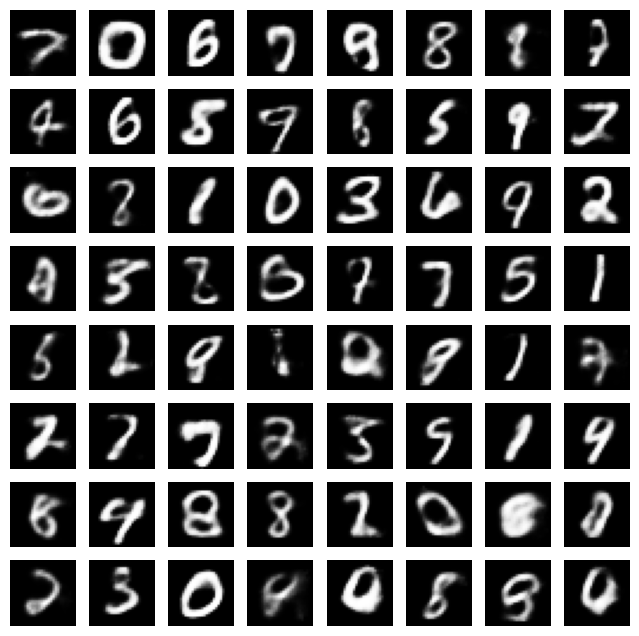

In [11]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Define hyperparameters
input_dim = 784
hidden_dim = 256
latent_dim = 20
batch_size = 64

# Load MNIST dataset
mnist = MNIST(download=True, root="data", transform=ToTensor())
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Create an instance of the VAE model
vae = VAE1(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

# Define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        # Flatten the images
        images = images.view(-1, input_dim)
        
        # Compute the reconstruction loss and the KL divergence
        x_recon, mu, logvar = vae(images)
        reconstruction_loss = torch.nn.functional.binary_cross_entropy(x_recon, images, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Compute the total loss and perform backpropagation
        total_loss = reconstruction_loss + kl_divergence
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
   
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Total Loss: {total_loss.item():.4f}")
    
    # Visualize some reconstructed images
with torch.no_grad():
    sample = torch.randn(64, latent_dim)
    reconstructed_images = vae.decode(sample).view(-1, 1, 28, 28)
    plt.figure(figsize=(8, 8))
    for j in range(64):
        plt.subplot(8, 8, j+1)
        plt.imshow(reconstructed_images[j].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()
